# Vision-Guided Cross-Attention and Late-Fusion Network

In [1]:
import os
os.environ['http_proxy'] = "http://192.41.170.23:3128" 
os.environ['https_proxy'] = "http://192.41.170.23:3128"

### Import Necessary Libraries and Environment Setup

In [3]:
#!pip uninstall -y transformers tokenizers
#!pip install transformers==4.9.0 tokenizers==0.10.1

In [4]:
import os
from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from datasets import load_dataset, set_caching_enabled
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from transformers import (
    # Preprocessing / Common
    AutoTokenizer, AutoFeatureExtractor,
    # Text & Image Models (Now, image transformers like ViTModel, DeiTModel, BEiT can also be loaded using AutoModel)
    AutoModel,
    # Training / Evaluation
    TrainingArguments, Trainer,
    # Misc
    logging
)

# import nltk
# nltk.download('wordnet')
from nltk.corpus import wordnet

from sklearn.metrics import accuracy_score, f1_score

In [5]:
# SET CACHE FOR HUGGINGFACE TRANSFORMERS + DATASETS
os.environ['HF_HOME'] = os.path.join(".", "cache")
# SET ONLY 1 GPU DEVICE
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

set_caching_enabled(True)
logging.set_verbosity_error()

/tmp/ipykernel_1568312/965404445.py:6: FutureWarning: set_caching_enabled is deprecated and will be removed in the next major version of datasets. Use datasets.enable_caching() or datasets.disable_caching() instead. This function will be removed in a future version of datasets.
  set_caching_enabled(True)


In [6]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)

#Additional Info when using cuda
# if device.type == 'cuda':
    # print(torch.cuda.get_device_name(0))
#     print('Memory Usage:')
#     print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
#     print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

cuda:1


### Load the Dataset

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
import os
import pandas as pd
from datasets import load_dataset

# Define the path to the train.csv and val.csv files
train_file = "pslake_train.csv"
val_file = "pslake_val.csv"

# Load the train and val datasets
train_dataset = load_dataset("csv", data_files=train_file, split="train")
val_dataset = load_dataset("csv", data_files=val_file, split="train")

# Extract the answers from the datasets
train_answers = train_dataset["answer"]
val_answers = val_dataset["answer"]

# Build the answer space
answer_space = set(train_answers + val_answers)
answer_space = list(answer_space)

# Map the answers to label indices
def map_to_label(example):
    labels = [
        answer_space.index(answer) if answer in answer_space else -1
        for answer in example["answer"]
    ]
    return {"label": labels}

# Apply the mapping function to the train and val datasets
train_dataset = train_dataset.map(map_to_label, batched=True)
val_dataset = val_dataset.map(map_to_label, batched=True)

# Print the updated datasets
print(train_dataset)
print(val_dataset)


Found cached dataset csv (/home/aimanl/.cache/huggingface/datasets/csv/default-646f062ba88072ac/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)
Found cached dataset csv (/home/aimanl/.cache/huggingface/datasets/csv/default-c504ceee5a67fb34/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


Map:   0%|          | 0/4919 [00:00<?, ? examples/s]

Map:   0%|          | 0/1053 [00:00<?, ? examples/s]

Dataset({
    features: ['img_id', 'img_name', 'question', 'answer', 'q_lang', 'location', 'modality', 'answer_type', 'base_type', 'content_type', 'triple/0', 'triple/1', 'triple/2', 'qid', 'label'],
    num_rows: 4919
})
Dataset({
    features: ['img_id', 'img_name', 'question', 'answer', 'q_lang', 'location', 'modality', 'answer_type', 'base_type', 'content_type', 'triple/0', 'triple/1', 'triple/2', 'qid', 'label'],
    num_rows: 1053
})


### Check VQA Sample

In [9]:
len(answer_space)

232

In [10]:
from PIL import Image
import os
import numpy as np
from IPython.display import display

def preprocess_images(image_ids):
    image_folder = "imgs"
    images = []
    for image_id in image_ids:
        image_path = os.path.join(image_folder, image_id)
        image = Image.open(image_path).convert('RGB')
        images.append(image)
    return images

def showExample(train=True, example_id=None):
    if train:
        dataset = train_dataset
    else:
        dataset = val_dataset
    if example_id is None:
        example_id = np.random.randint(len(dataset))

    image_id = dataset[example_id]["img_name"]
    image = Image.open(os.path.join("imgs", image_id))
    display(image.reduce(2))

    print("Question:\t", dataset[example_id]["question"])
    print("Answer:\t\t", dataset[example_id]["answer"], "(Label: {0})".format(dataset[example_id]["label"]))


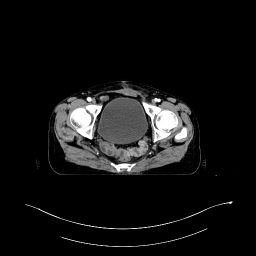

Question:	 What is the shape of femoral head in this image?
Answer:		 Circular (Label: 203)


In [11]:
showExample(train=True)

### Create a Multimodal Collator

This will be used in the `Trainer()` to automatically create the `Dataloader` from the dataset to pass inputs to the model

The collator will process the **question (text)** & the **image**, and return the **tokenized text** along with the **featurized image**. These will be fed into our multimodal transformer model for VQA.

In [12]:
@dataclass
class MultimodalCollator:
    tokenizer: AutoTokenizer
    preprocessor: AutoFeatureExtractor

    def tokenize_text(self, texts: List[str]):
        encoded_text = self.tokenizer(
            text=texts,
            padding='longest',
            max_length=24,
            truncation=True,
            return_tensors='pt',
            return_token_type_ids=True,
            return_attention_mask=True,
        )
        return {
            "input_ids": encoded_text['input_ids'].squeeze(),
            "token_type_ids": encoded_text['token_type_ids'].squeeze(),
            "attention_mask": encoded_text['attention_mask'].squeeze(),
        }

    def preprocess_images(self, images: List[str]):
        processed_images = self.preprocessor(
            images=[Image.open(os.path.join("imgs", image_id)).convert('RGB') for image_id in images],
            return_tensors="pt",
        )
        return {
            "pixel_values": processed_images['pixel_values'].squeeze(),
        }

    def __call__(self, raw_batch_dict):
        return {
            **self.tokenize_text(
                raw_batch_dict['question']
                if isinstance(raw_batch_dict, dict) else
                [i['question'] for i in raw_batch_dict]
            ),
            **self.preprocess_images(
                raw_batch_dict['img_name']
                if isinstance(raw_batch_dict, dict) else
                [i['img_name'] for i in raw_batch_dict]
            ),
            'labels': torch.tensor(
                raw_batch_dict['label']
                if isinstance(raw_batch_dict, dict) else
                [i['label'] for i in raw_batch_dict],
                dtype=torch.int64
            ),
        }

### Define VG-CALF Model Architecture

Multimodal models can be of various forms to capture information from the text & image modalities, along with some cross-modal interaction as well.
Here, we implemented **"Vision-Guided Cross-Attention"** and **"Fusion"** modules, to enhance inter-modality relationship between the text encoder & image encoder to perform VQA with radiology images.

The text encoder can be a text-based transformer model like BERT, while the image encoder could be an image transformer, such as ViT. After passing the tokenized question through the text-based transformer & the image features through the image transformer, these modules are applied and the outputs are passed through fully-connected linear layers.

In [13]:
# import clip

import torch
import torch.nn as nn
from transformers import AutoModel
from typing import Optional

import torch
import torch.nn as nn
from transformers import AutoModel
from typing import Optional

class MultimodalVQAModel(nn.Module):
    def __init__(
            self,
            num_labels: int = len(answer_space),
            intermediate_dim: int = 512,
            pretrained_text_name: str = 'emilyalsentzer/Bio_ClinicalBERT',
            pretrained_image_name: str = 'google/vit-base-patch16-384'):

        super(MultimodalVQAModel, self).__init__()
        self.num_labels = num_labels
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name

        self.text_encoder = AutoModel.from_pretrained(self.pretrained_text_name)
        self.image_encoder = AutoModel.from_pretrained(self.pretrained_image_name)

        # Vision-Guided Cross-Attention module
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=self.text_encoder.config.hidden_size,
            num_heads=16,  # Adjust as needed
        )
        
        # Late-Fusion module
        self.fusion = nn.Sequential(
            nn.Linear(1536, 1024),
            nn.LayerNorm(1024),
            nn.ReLU(),
            nn.Linear(1024, intermediate_dim),  # Add text features
            nn.LayerNorm(intermediate_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
        ) 

        self.classifier = nn.Linear(intermediate_dim, self.num_labels)

        self.criterion = nn.CrossEntropyLoss()

    def forward(
            self,
            input_ids: torch.LongTensor,
            pixel_values: torch.FloatTensor,
            attention_mask: Optional[torch.LongTensor] = None,
            token_type_ids: Optional[torch.LongTensor] = None,
            labels: Optional[torch.LongTensor] = None):

        encoded_text = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )
        encoded_image = self.image_encoder(
            pixel_values=pixel_values,
            return_dict=True,
        )

        # Apply cross-attention (image attends to text)
        attended_image_features, _ = self.cross_attention(
            query=encoded_image['pooler_output'],
            key=encoded_text['pooler_output'],
            value=encoded_text['pooler_output'],
        )

        # Concatenate attended image features with text features
        fused_features = torch.cat(
            [encoded_text['pooler_output'], attended_image_features],
            dim=1
        )

        # Apply late fusion module
        fused_output = self.fusion(fused_features)

        logits = self.classifier(fused_output)

        out = {
            "logits": logits
        }
        if labels is not None:
            loss = self.criterion(logits, labels)
            out["loss"] = loss

        return out
             

### Define a Function for the Model and the Collator

We plan to experiment with pretrained text & image encoders for our model. So, we will have to create the corresponding collators along with the model (tokenizers, featurizers & models need to be loaded from same pretrained checkpoints).

In [14]:
def createMultimodalVQACollatorAndModel(text='emilyalsentzer/Bio_ClinicalBERT', image='google/vit-base-patch16-384'):
    tokenizer = AutoTokenizer.from_pretrained(text)
    preprocessor = AutoFeatureExtractor.from_pretrained(image)

    multi_collator = MultimodalCollator(
        tokenizer=tokenizer,
        preprocessor=preprocessor,
    )


    multi_model = MultimodalVQAModel(pretrained_text_name=text, pretrained_image_name=image).to(device)
    return multi_collator, multi_model

### Performance Metrics

In [15]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/aimanl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np
from typing import Tuple, Dict

def compute_metrics(eval_tuple: Tuple[np.ndarray, np.ndarray]) -> Dict[str, float]:
    logits, labels = eval_tuple
    preds = logits.argmax(axis=-1)
    
    # Convert labels and preds to lists of strings
    reference = [str(label) for label in labels]
    candidate = [str(pred) for pred in preds]

    # Calculate BLEU-1 score
    bleu_score = sentence_bleu([reference], candidate)

    return {
        # "wups": batch_wup_measure(labels, preds),
        "bleu": bleu_score,
        "acc": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='macro')
    }

### Model Training and Evaluation

In [21]:
# !pip install transformers==4.8.2

In [28]:
args = TrainingArguments(
    output_dir="checkpoint",
    seed=12345,
    evaluation_strategy="steps",
    eval_steps=154,
    logging_strategy="steps",
    logging_steps=154,
    save_strategy="steps",
    save_steps=154,
    save_total_limit=10,             # Save only the last 3 checkpoints at any given time while training
    metric_for_best_model='acc',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    remove_unused_columns=False,
    num_train_epochs=200,
    fp16=True,
    # warmup_ratio=0.01,
    # learning_rate=5e-4,
    # weight_decay=1e-4,
    # gradient_accumulation_steps=2,
    dataloader_num_workers=8,
    load_best_model_at_end=True,
) 

In [29]:
def createAndTrainModel(dataset, args, text_model='emilyalsentzer/Bio_ClinicalBERT', image_model='google/vit-base-patch16-384', multimodal_model='med-flamingo/med-flamingo'):
    collator, model = createMultimodalVQACollatorAndModel(text_model, image_model)

    multi_args = deepcopy(args)
    multi_args.output_dir = os.path.join("checkpoint")
    multi_trainer = Trainer(
        model,
        multi_args,
        train_dataset=dataset['train'],
        eval_dataset=dataset['test'],
        data_collator=collator,
        compute_metrics=compute_metrics
    )

    train_multi_metrics = multi_trainer.train()
    eval_multi_metrics = multi_trainer.evaluate()

    return collator, model, train_multi_metrics, eval_multi_metrics

In [30]:
#train_dataset = load_dataset(...)
#test_dataset = load_dataset(...)

# Combine the train and test datasets into a single dictionary
dataset = {'train': train_dataset, 'test': val_dataset}

# Call the createAndTrainModel function with the dataset argument
collator, model, train_multi_metrics, eval_multi_metrics = createAndTrainModel(dataset, args)


/home/aimanl/.local/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: st122876 (medvqa). Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.8544, 'learning_rate': 4.975e-05, 'epoch': 1.0}
{'eval_loss': 1.9703083038330078, 'eval_bleu': 0.290223771726261, 'eval_acc': 0.5470085470085471, 'eval_f1': 0.12322329958157946, 'eval_runtime': 45.2147, 'eval_samples_per_second': 23.289, 'eval_steps_per_second': 0.73, 'epoch': 1.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 1.6275, 'learning_rate': 4.9500000000000004e-05, 'epoch': 2.0}
{'eval_loss': 1.4390488862991333, 'eval_bleu': 0.35886764555640965, 'eval_acc': 0.630579297245964, 'eval_f1': 0.2318214777733621, 'eval_runtime': 47.3954, 'eval_samples_per_second': 22.217, 'eval_steps_per_second': 0.696, 'epoch': 2.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 1.2474, 'learning_rate': 4.9250000000000004e-05, 'epoch': 3.0}
{'eval_loss': 1.1596903800964355, 'eval_bleu': 0.470051211139602, 'eval_acc': 0.6609686609686609, 'eval_f1': 0.27645784222979375, 'eval_runtime': 28.8566, 'eval_samples_per_second': 36.491, 'eval_steps_per_second': 1.144, 'epoch': 3.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 1.0336, 'learning_rate': 4.9e-05, 'epoch': 4.0}
{'eval_loss': 1.0307657718658447, 'eval_bleu': 0.48679090373388434, 'eval_acc': 0.691358024691358, 'eval_f1': 0.30991449876464394, 'eval_runtime': 31.3614, 'eval_samples_per_second': 33.576, 'eval_steps_per_second': 1.052, 'epoch': 4.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.898, 'learning_rate': 4.875e-05, 'epoch': 5.0}
{'eval_loss': 0.87717604637146, 'eval_bleu': 0.5540597197510705, 'eval_acc': 0.7568850902184235, 'eval_f1': 0.41025494228208054, 'eval_runtime': 38.9144, 'eval_samples_per_second': 27.059, 'eval_steps_per_second': 0.848, 'epoch': 5.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.79, 'learning_rate': 4.85e-05, 'epoch': 6.0}
{'eval_loss': 0.7990809679031372, 'eval_bleu': 0.5863630395404653, 'eval_acc': 0.768281101614435, 'eval_f1': 0.4185825863504184, 'eval_runtime': 44.7491, 'eval_samples_per_second': 23.531, 'eval_steps_per_second': 0.737, 'epoch': 6.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.7109, 'learning_rate': 4.825e-05, 'epoch': 7.0}
{'eval_loss': 0.7509617209434509, 'eval_bleu': 0.5891060702600531, 'eval_acc': 0.7768281101614435, 'eval_f1': 0.4280837825741009, 'eval_runtime': 46.1002, 'eval_samples_per_second': 22.842, 'eval_steps_per_second': 0.716, 'epoch': 7.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6467, 'learning_rate': 4.8e-05, 'epoch': 8.0}
{'eval_loss': 0.7524719834327698, 'eval_bleu': 0.6041924870396923, 'eval_acc': 0.7806267806267806, 'eval_f1': 0.43309597234385805, 'eval_runtime': 50.9798, 'eval_samples_per_second': 20.655, 'eval_steps_per_second': 0.647, 'epoch': 8.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.6065, 'learning_rate': 4.775e-05, 'epoch': 9.0}
{'eval_loss': 0.6919481754302979, 'eval_bleu': 0.5984218010603243, 'eval_acc': 0.7844254510921178, 'eval_f1': 0.45573689190135397, 'eval_runtime': 43.9845, 'eval_samples_per_second': 23.94, 'eval_steps_per_second': 0.75, 'epoch': 9.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.5604, 'learning_rate': 4.75e-05, 'epoch': 10.0}
{'eval_loss': 0.6723563075065613, 'eval_bleu': 0.6253642703542814, 'eval_acc': 0.8015194681861348, 'eval_f1': 0.48261393498781535, 'eval_runtime': 40.5688, 'eval_samples_per_second': 25.956, 'eval_steps_per_second': 0.813, 'epoch': 10.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.5287, 'learning_rate': 4.7249999999999997e-05, 'epoch': 11.0}
{'eval_loss': 0.6330329775810242, 'eval_bleu': 0.6527388471195007, 'eval_acc': 0.8148148148148148, 'eval_f1': 0.5107162118306559, 'eval_runtime': 49.3924, 'eval_samples_per_second': 21.319, 'eval_steps_per_second': 0.668, 'epoch': 11.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.4914, 'learning_rate': 4.7e-05, 'epoch': 12.0}
{'eval_loss': 0.6367244124412537, 'eval_bleu': 0.6534354698070295, 'eval_acc': 0.8100664767331434, 'eval_f1': 0.5018756350564614, 'eval_runtime': 41.5166, 'eval_samples_per_second': 25.363, 'eval_steps_per_second': 0.795, 'epoch': 12.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.4708, 'learning_rate': 4.6750000000000005e-05, 'epoch': 13.0}
{'eval_loss': 0.6247721910476685, 'eval_bleu': 0.6591716010065117, 'eval_acc': 0.818613485280152, 'eval_f1': 0.5102687823708977, 'eval_runtime': 43.8347, 'eval_samples_per_second': 24.022, 'eval_steps_per_second': 0.753, 'epoch': 13.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.4424, 'learning_rate': 4.6500000000000005e-05, 'epoch': 14.0}
{'eval_loss': 0.6313349604606628, 'eval_bleu': 0.6665947038125792, 'eval_acc': 0.818613485280152, 'eval_f1': 0.5055355553052351, 'eval_runtime': 59.3596, 'eval_samples_per_second': 17.739, 'eval_steps_per_second': 0.556, 'epoch': 14.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.4019, 'learning_rate': 4.6250000000000006e-05, 'epoch': 15.0}
{'eval_loss': 0.6238195896148682, 'eval_bleu': 0.6571398468768469, 'eval_acc': 0.8024691358024691, 'eval_f1': 0.4791532533365744, 'eval_runtime': 40.5438, 'eval_samples_per_second': 25.972, 'eval_steps_per_second': 0.814, 'epoch': 15.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.3872, 'learning_rate': 4.600000000000001e-05, 'epoch': 16.0}
{'eval_loss': 0.6324524283409119, 'eval_bleu': 0.6542026397413535, 'eval_acc': 0.8176638176638177, 'eval_f1': 0.5206174422347255, 'eval_runtime': 31.3871, 'eval_samples_per_second': 33.549, 'eval_steps_per_second': 1.051, 'epoch': 16.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.3675, 'learning_rate': 4.575e-05, 'epoch': 17.0}
{'eval_loss': 0.6383151412010193, 'eval_bleu': 0.6552628920711898, 'eval_acc': 0.8091168091168092, 'eval_f1': 0.5148518800714328, 'eval_runtime': 30.2666, 'eval_samples_per_second': 34.791, 'eval_steps_per_second': 1.09, 'epoch': 17.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.3454, 'learning_rate': 4.55e-05, 'epoch': 18.0}
{'eval_loss': 0.6212016344070435, 'eval_bleu': 0.6582398999638636, 'eval_acc': 0.8148148148148148, 'eval_f1': 0.4935289052673583, 'eval_runtime': 26.0678, 'eval_samples_per_second': 40.395, 'eval_steps_per_second': 1.266, 'epoch': 18.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.3213, 'learning_rate': 4.525e-05, 'epoch': 19.0}
{'eval_loss': 0.6579954028129578, 'eval_bleu': 0.6732305315372434, 'eval_acc': 0.8176638176638177, 'eval_f1': 0.524136165428254, 'eval_runtime': 28.0446, 'eval_samples_per_second': 37.547, 'eval_steps_per_second': 1.177, 'epoch': 19.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.2923, 'learning_rate': 4.5e-05, 'epoch': 20.0}
{'eval_loss': 0.6648112535476685, 'eval_bleu': 0.6465163979653484, 'eval_acc': 0.8100664767331434, 'eval_f1': 0.4996383125692717, 'eval_runtime': 25.9683, 'eval_samples_per_second': 40.549, 'eval_steps_per_second': 1.271, 'epoch': 20.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.2818, 'learning_rate': 4.4750000000000004e-05, 'epoch': 21.0}
{'eval_loss': 0.6763989329338074, 'eval_bleu': 0.6655598404390446, 'eval_acc': 0.8148148148148148, 'eval_f1': 0.5135794941163591, 'eval_runtime': 27.6382, 'eval_samples_per_second': 38.099, 'eval_steps_per_second': 1.194, 'epoch': 21.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.2638, 'learning_rate': 4.4500000000000004e-05, 'epoch': 22.0}
{'eval_loss': 0.6544551253318787, 'eval_bleu': 0.6858878860076778, 'eval_acc': 0.8252611585944919, 'eval_f1': 0.5350704714856774, 'eval_runtime': 31.7545, 'eval_samples_per_second': 33.161, 'eval_steps_per_second': 1.039, 'epoch': 22.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.2472, 'learning_rate': 4.4250000000000005e-05, 'epoch': 23.0}
{'eval_loss': 0.6231167912483215, 'eval_bleu': 0.6825056690424345, 'eval_acc': 0.8205128205128205, 'eval_f1': 0.5086452311537586, 'eval_runtime': 31.9197, 'eval_samples_per_second': 32.989, 'eval_steps_per_second': 1.034, 'epoch': 23.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.228, 'learning_rate': 4.4000000000000006e-05, 'epoch': 24.0}
{'eval_loss': 0.6602461934089661, 'eval_bleu': 0.6995918340495679, 'eval_acc': 0.8319088319088319, 'eval_f1': 0.5232259764951018, 'eval_runtime': 40.88, 'eval_samples_per_second': 25.758, 'eval_steps_per_second': 0.807, 'epoch': 24.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.224, 'learning_rate': 4.375e-05, 'epoch': 25.0}
{'eval_loss': 0.6522948145866394, 'eval_bleu': 0.670170621540919, 'eval_acc': 0.8176638176638177, 'eval_f1': 0.5034101528613348, 'eval_runtime': 25.7971, 'eval_samples_per_second': 40.818, 'eval_steps_per_second': 1.279, 'epoch': 25.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.2067, 'learning_rate': 4.35e-05, 'epoch': 26.0}
{'eval_loss': 0.7041786313056946, 'eval_bleu': 0.6595307025561911, 'eval_acc': 0.8110161443494777, 'eval_f1': 0.4953581637016877, 'eval_runtime': 30.3576, 'eval_samples_per_second': 34.687, 'eval_steps_per_second': 1.087, 'epoch': 26.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.1867, 'learning_rate': 4.325e-05, 'epoch': 27.0}
{'eval_loss': 0.7180353403091431, 'eval_bleu': 0.6702867426951767, 'eval_acc': 0.8167141500474834, 'eval_f1': 0.5041622533444189, 'eval_runtime': 32.7725, 'eval_samples_per_second': 32.131, 'eval_steps_per_second': 1.007, 'epoch': 27.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.1772, 'learning_rate': 4.3e-05, 'epoch': 28.0}
{'eval_loss': 0.7191697359085083, 'eval_bleu': 0.6715563312081013, 'eval_acc': 0.8195631528964862, 'eval_f1': 0.49276101147593543, 'eval_runtime': 33.2788, 'eval_samples_per_second': 31.642, 'eval_steps_per_second': 0.992, 'epoch': 28.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.1638, 'learning_rate': 4.275e-05, 'epoch': 29.0}
{'eval_loss': 0.7023042440414429, 'eval_bleu': 0.673208282712922, 'eval_acc': 0.8205128205128205, 'eval_f1': 0.5062046145106522, 'eval_runtime': 42.2608, 'eval_samples_per_second': 24.917, 'eval_steps_per_second': 0.781, 'epoch': 29.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.1459, 'learning_rate': 4.25e-05, 'epoch': 30.0}
{'eval_loss': 0.7475561499595642, 'eval_bleu': 0.64910414376386, 'eval_acc': 0.8129154795821463, 'eval_f1': 0.49553713688060336, 'eval_runtime': 31.0771, 'eval_samples_per_second': 33.883, 'eval_steps_per_second': 1.062, 'epoch': 30.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.1461, 'learning_rate': 4.2250000000000004e-05, 'epoch': 31.0}
{'eval_loss': 0.7549381256103516, 'eval_bleu': 0.6672434246301983, 'eval_acc': 0.8148148148148148, 'eval_f1': 0.5187193387565302, 'eval_runtime': 33.0355, 'eval_samples_per_second': 31.875, 'eval_steps_per_second': 0.999, 'epoch': 31.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.1355, 'learning_rate': 4.2e-05, 'epoch': 32.0}
{'eval_loss': 0.7523567080497742, 'eval_bleu': 0.669473501088405, 'eval_acc': 0.8176638176638177, 'eval_f1': 0.48116337791049385, 'eval_runtime': 43.7171, 'eval_samples_per_second': 24.087, 'eval_steps_per_second': 0.755, 'epoch': 32.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.1189, 'learning_rate': 4.175e-05, 'epoch': 33.0}
{'eval_loss': 0.7549558281898499, 'eval_bleu': 0.6747511644897884, 'eval_acc': 0.8195631528964862, 'eval_f1': 0.5086064571087281, 'eval_runtime': 30.5633, 'eval_samples_per_second': 34.453, 'eval_steps_per_second': 1.08, 'epoch': 33.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.1166, 'learning_rate': 4.15e-05, 'epoch': 34.0}
{'eval_loss': 0.7665843963623047, 'eval_bleu': 0.6704441210123951, 'eval_acc': 0.8205128205128205, 'eval_f1': 0.5066207451486502, 'eval_runtime': 32.302, 'eval_samples_per_second': 32.599, 'eval_steps_per_second': 1.022, 'epoch': 34.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.1038, 'learning_rate': 4.125e-05, 'epoch': 35.0}
{'eval_loss': 0.8102123737335205, 'eval_bleu': 0.6620545671334294, 'eval_acc': 0.8100664767331434, 'eval_f1': 0.5082919314481049, 'eval_runtime': 35.7844, 'eval_samples_per_second': 29.426, 'eval_steps_per_second': 0.922, 'epoch': 35.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0989, 'learning_rate': 4.1e-05, 'epoch': 36.0}
{'eval_loss': 0.8189181685447693, 'eval_bleu': 0.6697258415667898, 'eval_acc': 0.8157644824311491, 'eval_f1': 0.5244539572640032, 'eval_runtime': 48.3941, 'eval_samples_per_second': 21.759, 'eval_steps_per_second': 0.682, 'epoch': 36.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0848, 'learning_rate': 4.075e-05, 'epoch': 37.0}
{'eval_loss': 0.8534647226333618, 'eval_bleu': 0.6464893244099202, 'eval_acc': 0.8100664767331434, 'eval_f1': 0.49805570742460215, 'eval_runtime': 30.1843, 'eval_samples_per_second': 34.886, 'eval_steps_per_second': 1.093, 'epoch': 37.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0801, 'learning_rate': 4.05e-05, 'epoch': 38.0}
{'eval_loss': 0.876679539680481, 'eval_bleu': 0.6655354438105195, 'eval_acc': 0.8148148148148148, 'eval_f1': 0.5405269270301574, 'eval_runtime': 32.7733, 'eval_samples_per_second': 32.13, 'eval_steps_per_second': 1.007, 'epoch': 38.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0684, 'learning_rate': 4.025e-05, 'epoch': 39.0}
{'eval_loss': 0.8919106125831604, 'eval_bleu': 0.661963185827385, 'eval_acc': 0.8138651471984806, 'eval_f1': 0.5280982833216938, 'eval_runtime': 39.6039, 'eval_samples_per_second': 26.588, 'eval_steps_per_second': 0.833, 'epoch': 39.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0635, 'learning_rate': 4e-05, 'epoch': 40.0}
{'eval_loss': 0.883010983467102, 'eval_bleu': 0.6614357236403564, 'eval_acc': 0.811965811965812, 'eval_f1': 0.5052950116386438, 'eval_runtime': 28.2891, 'eval_samples_per_second': 37.223, 'eval_steps_per_second': 1.167, 'epoch': 40.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.058, 'learning_rate': 3.9750000000000004e-05, 'epoch': 41.0}
{'eval_loss': 0.9486149549484253, 'eval_bleu': 0.670576706311577, 'eval_acc': 0.8138651471984806, 'eval_f1': 0.5294248549156981, 'eval_runtime': 30.5617, 'eval_samples_per_second': 34.455, 'eval_steps_per_second': 1.08, 'epoch': 41.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0567, 'learning_rate': 3.9500000000000005e-05, 'epoch': 42.0}
{'eval_loss': 0.888778805732727, 'eval_bleu': 0.674455650327882, 'eval_acc': 0.8195631528964862, 'eval_f1': 0.5149323586717885, 'eval_runtime': 33.0166, 'eval_samples_per_second': 31.893, 'eval_steps_per_second': 0.999, 'epoch': 42.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0498, 'learning_rate': 3.9250000000000005e-05, 'epoch': 43.0}
{'eval_loss': 0.9884414672851562, 'eval_bleu': 0.6569707586295243, 'eval_acc': 0.8072174738841406, 'eval_f1': 0.4998544327908854, 'eval_runtime': 35.9648, 'eval_samples_per_second': 29.279, 'eval_steps_per_second': 0.918, 'epoch': 43.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0432, 'learning_rate': 3.9000000000000006e-05, 'epoch': 44.0}
{'eval_loss': 0.9069074392318726, 'eval_bleu': 0.6960506324941136, 'eval_acc': 0.8281101614434948, 'eval_f1': 0.5595449043424768, 'eval_runtime': 47.2129, 'eval_samples_per_second': 22.303, 'eval_steps_per_second': 0.699, 'epoch': 44.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0378, 'learning_rate': 3.875e-05, 'epoch': 45.0}
{'eval_loss': 0.9738317131996155, 'eval_bleu': 0.6831479351113706, 'eval_acc': 0.8167141500474834, 'eval_f1': 0.5195184116302868, 'eval_runtime': 26.2985, 'eval_samples_per_second': 40.04, 'eval_steps_per_second': 1.255, 'epoch': 45.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.035, 'learning_rate': 3.85e-05, 'epoch': 46.0}
{'eval_loss': 0.958960235118866, 'eval_bleu': 0.6779652777912871, 'eval_acc': 0.8224121557454891, 'eval_f1': 0.5328872832272057, 'eval_runtime': 31.9486, 'eval_samples_per_second': 32.959, 'eval_steps_per_second': 1.033, 'epoch': 46.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0295, 'learning_rate': 3.825e-05, 'epoch': 47.0}
{'eval_loss': 0.996418833732605, 'eval_bleu': 0.6743514610832548, 'eval_acc': 0.8195631528964862, 'eval_f1': 0.521085264008883, 'eval_runtime': 32.0103, 'eval_samples_per_second': 32.896, 'eval_steps_per_second': 1.031, 'epoch': 47.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.028, 'learning_rate': 3.8e-05, 'epoch': 48.0}
{'eval_loss': 0.9701168537139893, 'eval_bleu': 0.689038730912012, 'eval_acc': 0.8252611585944919, 'eval_f1': 0.5091528149900794, 'eval_runtime': 35.8679, 'eval_samples_per_second': 29.358, 'eval_steps_per_second': 0.92, 'epoch': 48.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0219, 'learning_rate': 3.775e-05, 'epoch': 49.0}
{'eval_loss': 1.026624083518982, 'eval_bleu': 0.6720143757295995, 'eval_acc': 0.8157644824311491, 'eval_f1': 0.5173709906870416, 'eval_runtime': 45.9615, 'eval_samples_per_second': 22.91, 'eval_steps_per_second': 0.718, 'epoch': 49.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.02, 'learning_rate': 3.7500000000000003e-05, 'epoch': 50.0}
{'eval_loss': 1.0054442882537842, 'eval_bleu': 0.6784101263114315, 'eval_acc': 0.8195631528964862, 'eval_f1': 0.5439355163703089, 'eval_runtime': 21.494, 'eval_samples_per_second': 48.99, 'eval_steps_per_second': 1.535, 'epoch': 50.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0199, 'learning_rate': 3.7250000000000004e-05, 'epoch': 51.0}
{'eval_loss': 1.0910505056381226, 'eval_bleu': 0.6815861619744173, 'eval_acc': 0.8233618233618234, 'eval_f1': 0.5285376677975034, 'eval_runtime': 32.4253, 'eval_samples_per_second': 32.475, 'eval_steps_per_second': 1.018, 'epoch': 51.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0184, 'learning_rate': 3.7e-05, 'epoch': 52.0}
{'eval_loss': 1.0570722818374634, 'eval_bleu': 0.6589924534077097, 'eval_acc': 0.8100664767331434, 'eval_f1': 0.502039121215128, 'eval_runtime': 32.6734, 'eval_samples_per_second': 32.228, 'eval_steps_per_second': 1.01, 'epoch': 52.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0164, 'learning_rate': 3.675e-05, 'epoch': 53.0}
{'eval_loss': 1.0896300077438354, 'eval_bleu': 0.6661465463713673, 'eval_acc': 0.818613485280152, 'eval_f1': 0.536486134899662, 'eval_runtime': 38.8171, 'eval_samples_per_second': 27.127, 'eval_steps_per_second': 0.85, 'epoch': 53.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0189, 'learning_rate': 3.65e-05, 'epoch': 54.0}
{'eval_loss': 1.0619466304779053, 'eval_bleu': 0.6705881712635724, 'eval_acc': 0.8167141500474834, 'eval_f1': 0.5277084480215891, 'eval_runtime': 34.0059, 'eval_samples_per_second': 30.965, 'eval_steps_per_second': 0.97, 'epoch': 54.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0132, 'learning_rate': 3.625e-05, 'epoch': 55.0}
{'eval_loss': 1.1527817249298096, 'eval_bleu': 0.6751488261812114, 'eval_acc': 0.8205128205128205, 'eval_f1': 0.519552139590899, 'eval_runtime': 24.7777, 'eval_samples_per_second': 42.498, 'eval_steps_per_second': 1.332, 'epoch': 55.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0127, 'learning_rate': 3.6e-05, 'epoch': 56.0}
{'eval_loss': 1.1935923099517822, 'eval_bleu': 0.6689909354646528, 'eval_acc': 0.8157644824311491, 'eval_f1': 0.5269626466597024, 'eval_runtime': 32.097, 'eval_samples_per_second': 32.807, 'eval_steps_per_second': 1.028, 'epoch': 56.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0102, 'learning_rate': 3.575e-05, 'epoch': 57.0}
{'eval_loss': 1.1930538415908813, 'eval_bleu': 0.6738410646745424, 'eval_acc': 0.8167141500474834, 'eval_f1': 0.5033749048317979, 'eval_runtime': 31.7681, 'eval_samples_per_second': 33.146, 'eval_steps_per_second': 1.039, 'epoch': 57.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0114, 'learning_rate': 3.55e-05, 'epoch': 58.0}
{'eval_loss': 1.19077730178833, 'eval_bleu': 0.6745120831622964, 'eval_acc': 0.818613485280152, 'eval_f1': 0.5263605118306339, 'eval_runtime': 38.2203, 'eval_samples_per_second': 27.551, 'eval_steps_per_second': 0.863, 'epoch': 58.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0085, 'learning_rate': 3.525e-05, 'epoch': 59.0}
{'eval_loss': 1.2383973598480225, 'eval_bleu': 0.6764269254626634, 'eval_acc': 0.8195631528964862, 'eval_f1': 0.5291061272320442, 'eval_runtime': 20.5969, 'eval_samples_per_second': 51.124, 'eval_steps_per_second': 1.602, 'epoch': 59.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0076, 'learning_rate': 3.5e-05, 'epoch': 60.0}
{'eval_loss': 1.289976954460144, 'eval_bleu': 0.6672758952089033, 'eval_acc': 0.8148148148148148, 'eval_f1': 0.5191722816998958, 'eval_runtime': 32.2839, 'eval_samples_per_second': 32.617, 'eval_steps_per_second': 1.022, 'epoch': 60.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.006, 'learning_rate': 3.475e-05, 'epoch': 61.0}
{'eval_loss': 1.2826075553894043, 'eval_bleu': 0.6859975848919337, 'eval_acc': 0.8176638176638177, 'eval_f1': 0.5205918347096553, 'eval_runtime': 40.4967, 'eval_samples_per_second': 26.002, 'eval_steps_per_second': 0.815, 'epoch': 61.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0043, 'learning_rate': 3.45e-05, 'epoch': 62.0}
{'eval_loss': 1.2898491621017456, 'eval_bleu': 0.6666662558566885, 'eval_acc': 0.8176638176638177, 'eval_f1': 0.5298135182945042, 'eval_runtime': 19.4103, 'eval_samples_per_second': 54.25, 'eval_steps_per_second': 1.7, 'epoch': 62.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0111, 'learning_rate': 3.4250000000000006e-05, 'epoch': 63.0}
{'eval_loss': 1.1839041709899902, 'eval_bleu': 0.6882468949630681, 'eval_acc': 0.8281101614434948, 'eval_f1': 0.5383620231223247, 'eval_runtime': 44.4171, 'eval_samples_per_second': 23.707, 'eval_steps_per_second': 0.743, 'epoch': 63.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0037, 'learning_rate': 3.4000000000000007e-05, 'epoch': 64.0}
{'eval_loss': 1.308824896812439, 'eval_bleu': 0.6847663075321195, 'eval_acc': 0.8224121557454891, 'eval_f1': 0.5388188300999347, 'eval_runtime': 51.7437, 'eval_samples_per_second': 20.35, 'eval_steps_per_second': 0.638, 'epoch': 64.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0149, 'learning_rate': 3.375000000000001e-05, 'epoch': 65.0}
{'eval_loss': 1.399810552597046, 'eval_bleu': 0.6599864923357156, 'eval_acc': 0.811965811965812, 'eval_f1': 0.51627653426327, 'eval_runtime': 43.3876, 'eval_samples_per_second': 24.27, 'eval_steps_per_second': 0.761, 'epoch': 65.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0042, 'learning_rate': 3.35e-05, 'epoch': 66.0}
{'eval_loss': 1.3824126720428467, 'eval_bleu': 0.6806711010590769, 'eval_acc': 0.8233618233618234, 'eval_f1': 0.5490315208609663, 'eval_runtime': 39.4487, 'eval_samples_per_second': 26.693, 'eval_steps_per_second': 0.837, 'epoch': 66.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.008, 'learning_rate': 3.325e-05, 'epoch': 67.0}
{'eval_loss': 1.4975688457489014, 'eval_bleu': 0.6802343518442037, 'eval_acc': 0.8224121557454891, 'eval_f1': 0.5374270005167686, 'eval_runtime': 46.8243, 'eval_samples_per_second': 22.488, 'eval_steps_per_second': 0.705, 'epoch': 67.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0079, 'learning_rate': 3.3e-05, 'epoch': 68.0}
{'eval_loss': 1.356245994567871, 'eval_bleu': 0.6839063092464944, 'eval_acc': 0.8262108262108262, 'eval_f1': 0.5359003611065549, 'eval_runtime': 26.9851, 'eval_samples_per_second': 39.022, 'eval_steps_per_second': 1.223, 'epoch': 68.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0068, 'learning_rate': 3.275e-05, 'epoch': 69.0}
{'eval_loss': 1.4571633338928223, 'eval_bleu': 0.6797181105628497, 'eval_acc': 0.818613485280152, 'eval_f1': 0.5225464561263324, 'eval_runtime': 40.8714, 'eval_samples_per_second': 25.764, 'eval_steps_per_second': 0.807, 'epoch': 69.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0082, 'learning_rate': 3.2500000000000004e-05, 'epoch': 70.0}
{'eval_loss': 1.4940266609191895, 'eval_bleu': 0.677859806670714, 'eval_acc': 0.8233618233618234, 'eval_f1': 0.5229611066805723, 'eval_runtime': 48.6022, 'eval_samples_per_second': 21.666, 'eval_steps_per_second': 0.679, 'epoch': 70.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0022, 'learning_rate': 3.2250000000000005e-05, 'epoch': 71.0}
{'eval_loss': 1.4462167024612427, 'eval_bleu': 0.6860011224457858, 'eval_acc': 0.8205128205128205, 'eval_f1': 0.5197752217725549, 'eval_runtime': 58.4756, 'eval_samples_per_second': 18.008, 'eval_steps_per_second': 0.564, 'epoch': 71.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0026, 'learning_rate': 3.2000000000000005e-05, 'epoch': 72.0}
{'eval_loss': 1.4843652248382568, 'eval_bleu': 0.6705092004189943, 'eval_acc': 0.8148148148148148, 'eval_f1': 0.5328323687458071, 'eval_runtime': 44.5373, 'eval_samples_per_second': 23.643, 'eval_steps_per_second': 0.741, 'epoch': 72.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0012, 'learning_rate': 3.175e-05, 'epoch': 73.0}
{'eval_loss': 1.525631070137024, 'eval_bleu': 0.6753457636981346, 'eval_acc': 0.8205128205128205, 'eval_f1': 0.5305187103409732, 'eval_runtime': 44.3387, 'eval_samples_per_second': 23.749, 'eval_steps_per_second': 0.744, 'epoch': 73.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0009, 'learning_rate': 3.15e-05, 'epoch': 74.0}
{'eval_loss': 1.4788167476654053, 'eval_bleu': 0.6912168875526551, 'eval_acc': 0.8233618233618234, 'eval_f1': 0.5381455320413913, 'eval_runtime': 43.0312, 'eval_samples_per_second': 24.471, 'eval_steps_per_second': 0.767, 'epoch': 74.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0047, 'learning_rate': 3.125e-05, 'epoch': 75.0}
{'eval_loss': 1.521642804145813, 'eval_bleu': 0.6894477343173806, 'eval_acc': 0.8271604938271605, 'eval_f1': 0.5529566561867637, 'eval_runtime': 44.3836, 'eval_samples_per_second': 23.725, 'eval_steps_per_second': 0.744, 'epoch': 75.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0007, 'learning_rate': 3.1e-05, 'epoch': 76.0}
{'eval_loss': 1.5751570463180542, 'eval_bleu': 0.6829306076786521, 'eval_acc': 0.8176638176638177, 'eval_f1': 0.5209268203360874, 'eval_runtime': 37.7076, 'eval_samples_per_second': 27.925, 'eval_steps_per_second': 0.875, 'epoch': 76.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0007, 'learning_rate': 3.075e-05, 'epoch': 77.0}
{'eval_loss': 1.6035659313201904, 'eval_bleu': 0.6793446151305569, 'eval_acc': 0.8205128205128205, 'eval_f1': 0.5456891336210267, 'eval_runtime': 34.818, 'eval_samples_per_second': 30.243, 'eval_steps_per_second': 0.948, 'epoch': 77.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0015, 'learning_rate': 3.05e-05, 'epoch': 78.0}
{'eval_loss': 1.6242930889129639, 'eval_bleu': 0.6794911449447817, 'eval_acc': 0.8205128205128205, 'eval_f1': 0.5292372412680958, 'eval_runtime': 23.738, 'eval_samples_per_second': 44.359, 'eval_steps_per_second': 1.39, 'epoch': 78.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0013, 'learning_rate': 3.025e-05, 'epoch': 79.0}
{'eval_loss': 1.6626710891723633, 'eval_bleu': 0.6814938881209656, 'eval_acc': 0.8214624881291548, 'eval_f1': 0.5190548009059351, 'eval_runtime': 33.038, 'eval_samples_per_second': 31.872, 'eval_steps_per_second': 0.999, 'epoch': 79.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0007, 'learning_rate': 3e-05, 'epoch': 80.0}
{'eval_loss': 1.7289166450500488, 'eval_bleu': 0.6801218484492739, 'eval_acc': 0.818613485280152, 'eval_f1': 0.5227874298224033, 'eval_runtime': 33.4628, 'eval_samples_per_second': 31.468, 'eval_steps_per_second': 0.986, 'epoch': 80.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0011, 'learning_rate': 2.975e-05, 'epoch': 81.0}
{'eval_loss': 1.70449697971344, 'eval_bleu': 0.7014736577666264, 'eval_acc': 0.8271604938271605, 'eval_f1': 0.5584034783683614, 'eval_runtime': 28.2689, 'eval_samples_per_second': 37.249, 'eval_steps_per_second': 1.167, 'epoch': 81.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0038, 'learning_rate': 2.95e-05, 'epoch': 82.0}
{'eval_loss': 1.6453536748886108, 'eval_bleu': 0.6901184501768017, 'eval_acc': 0.8271604938271605, 'eval_f1': 0.5374302767007263, 'eval_runtime': 36.3584, 'eval_samples_per_second': 28.962, 'eval_steps_per_second': 0.908, 'epoch': 82.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0002, 'learning_rate': 2.925e-05, 'epoch': 83.0}
{'eval_loss': 1.6568342447280884, 'eval_bleu': 0.6937285301617081, 'eval_acc': 0.8271604938271605, 'eval_f1': 0.5441115785489363, 'eval_runtime': 47.1148, 'eval_samples_per_second': 22.35, 'eval_steps_per_second': 0.7, 'epoch': 83.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0018, 'learning_rate': 2.9e-05, 'epoch': 84.0}
{'eval_loss': 1.7973265647888184, 'eval_bleu': 0.6819841393239142, 'eval_acc': 0.8214624881291548, 'eval_f1': 0.5285567550548552, 'eval_runtime': 44.0873, 'eval_samples_per_second': 23.884, 'eval_steps_per_second': 0.749, 'epoch': 84.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0084, 'learning_rate': 2.8749999999999997e-05, 'epoch': 85.0}
{'eval_loss': 1.7878977060317993, 'eval_bleu': 0.684003224453486, 'eval_acc': 0.8205128205128205, 'eval_f1': 0.5531165321991522, 'eval_runtime': 37.9165, 'eval_samples_per_second': 27.772, 'eval_steps_per_second': 0.87, 'epoch': 85.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0002, 'learning_rate': 2.8499999999999998e-05, 'epoch': 86.0}
{'eval_loss': 1.8518049716949463, 'eval_bleu': 0.6795088331512729, 'eval_acc': 0.818613485280152, 'eval_f1': 0.541333936851291, 'eval_runtime': 52.2325, 'eval_samples_per_second': 20.16, 'eval_steps_per_second': 0.632, 'epoch': 86.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0008, 'learning_rate': 2.825e-05, 'epoch': 87.0}
{'eval_loss': 1.8465347290039062, 'eval_bleu': 0.6928218807850005, 'eval_acc': 0.8271604938271605, 'eval_f1': 0.5529601381849952, 'eval_runtime': 51.9254, 'eval_samples_per_second': 20.279, 'eval_steps_per_second': 0.636, 'epoch': 87.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0016, 'learning_rate': 2.8000000000000003e-05, 'epoch': 88.0}
{'eval_loss': 1.9020792245864868, 'eval_bleu': 0.6768503873660945, 'eval_acc': 0.818613485280152, 'eval_f1': 0.5216151616742203, 'eval_runtime': 43.9326, 'eval_samples_per_second': 23.969, 'eval_steps_per_second': 0.751, 'epoch': 88.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0005, 'learning_rate': 2.7750000000000004e-05, 'epoch': 89.0}
{'eval_loss': 1.9109830856323242, 'eval_bleu': 0.6791776440465843, 'eval_acc': 0.8195631528964862, 'eval_f1': 0.5515731312362505, 'eval_runtime': 46.043, 'eval_samples_per_second': 22.87, 'eval_steps_per_second': 0.717, 'epoch': 89.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0095, 'learning_rate': 2.7500000000000004e-05, 'epoch': 90.0}
{'eval_loss': 1.9212770462036133, 'eval_bleu': 0.683305089788016, 'eval_acc': 0.8214624881291548, 'eval_f1': 0.5376153634178694, 'eval_runtime': 51.8131, 'eval_samples_per_second': 20.323, 'eval_steps_per_second': 0.637, 'epoch': 90.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0004, 'learning_rate': 2.725e-05, 'epoch': 91.0}
{'eval_loss': 1.9848062992095947, 'eval_bleu': 0.6780671881116886, 'eval_acc': 0.8195631528964862, 'eval_f1': 0.5468977101714708, 'eval_runtime': 32.111, 'eval_samples_per_second': 32.793, 'eval_steps_per_second': 1.028, 'epoch': 91.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0002, 'learning_rate': 2.7000000000000002e-05, 'epoch': 92.0}
{'eval_loss': 1.959283709526062, 'eval_bleu': 0.6778599080983715, 'eval_acc': 0.8214624881291548, 'eval_f1': 0.5369456755901306, 'eval_runtime': 36.1464, 'eval_samples_per_second': 29.132, 'eval_steps_per_second': 0.913, 'epoch': 92.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0003, 'learning_rate': 2.6750000000000003e-05, 'epoch': 93.0}
{'eval_loss': 1.9377923011779785, 'eval_bleu': 0.6789074925772296, 'eval_acc': 0.8205128205128205, 'eval_f1': 0.5130132584147932, 'eval_runtime': 31.1525, 'eval_samples_per_second': 33.802, 'eval_steps_per_second': 1.059, 'epoch': 93.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0001, 'learning_rate': 2.6500000000000004e-05, 'epoch': 94.0}
{'eval_loss': 2.0443708896636963, 'eval_bleu': 0.6893503488204182, 'eval_acc': 0.8233618233618234, 'eval_f1': 0.5421200580248542, 'eval_runtime': 40.779, 'eval_samples_per_second': 25.822, 'eval_steps_per_second': 0.809, 'epoch': 94.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0001, 'learning_rate': 2.625e-05, 'epoch': 95.0}
{'eval_loss': 2.1715457439422607, 'eval_bleu': 0.6732458902214633, 'eval_acc': 0.8138651471984806, 'eval_f1': 0.5206943380156918, 'eval_runtime': 40.3218, 'eval_samples_per_second': 26.115, 'eval_steps_per_second': 0.818, 'epoch': 95.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0001, 'learning_rate': 2.6000000000000002e-05, 'epoch': 96.0}
{'eval_loss': 2.138758659362793, 'eval_bleu': 0.6837656710016161, 'eval_acc': 0.818613485280152, 'eval_f1': 0.5551084549941905, 'eval_runtime': 48.4566, 'eval_samples_per_second': 21.731, 'eval_steps_per_second': 0.681, 'epoch': 96.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0015, 'learning_rate': 2.5750000000000002e-05, 'epoch': 97.0}
{'eval_loss': 2.1430017948150635, 'eval_bleu': 0.6727536392973604, 'eval_acc': 0.8176638176638177, 'eval_f1': 0.5308530888583495, 'eval_runtime': 49.3591, 'eval_samples_per_second': 21.333, 'eval_steps_per_second': 0.669, 'epoch': 97.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0034, 'learning_rate': 2.5500000000000003e-05, 'epoch': 98.0}
{'eval_loss': 2.1599864959716797, 'eval_bleu': 0.6796124950862065, 'eval_acc': 0.8157644824311491, 'eval_f1': 0.5350669629723894, 'eval_runtime': 45.8737, 'eval_samples_per_second': 22.954, 'eval_steps_per_second': 0.719, 'epoch': 98.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0001, 'learning_rate': 2.525e-05, 'epoch': 99.0}
{'eval_loss': 2.10638427734375, 'eval_bleu': 0.6913543324453623, 'eval_acc': 0.8205128205128205, 'eval_f1': 0.5374824586723327, 'eval_runtime': 44.33, 'eval_samples_per_second': 23.754, 'eval_steps_per_second': 0.744, 'epoch': 99.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 2.5e-05, 'epoch': 100.0}
{'eval_loss': 2.0549073219299316, 'eval_bleu': 0.6915946274588349, 'eval_acc': 0.8262108262108262, 'eval_f1': 0.5516962209186295, 'eval_runtime': 43.9391, 'eval_samples_per_second': 23.965, 'eval_steps_per_second': 0.751, 'epoch': 100.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0084, 'learning_rate': 2.4750000000000002e-05, 'epoch': 101.0}
{'eval_loss': 2.2127394676208496, 'eval_bleu': 0.689592709711989, 'eval_acc': 0.8233618233618234, 'eval_f1': 0.557364549542217, 'eval_runtime': 44.0544, 'eval_samples_per_second': 23.902, 'eval_steps_per_second': 0.749, 'epoch': 101.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0029, 'learning_rate': 2.45e-05, 'epoch': 102.0}
{'eval_loss': 2.118711233139038, 'eval_bleu': 0.6926231551482859, 'eval_acc': 0.8233618233618234, 'eval_f1': 0.545573675943595, 'eval_runtime': 36.0782, 'eval_samples_per_second': 29.187, 'eval_steps_per_second': 0.915, 'epoch': 102.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0016, 'learning_rate': 2.425e-05, 'epoch': 103.0}
{'eval_loss': 2.2015342712402344, 'eval_bleu': 0.6857745580441978, 'eval_acc': 0.8205128205128205, 'eval_f1': 0.5452998548103213, 'eval_runtime': 47.1021, 'eval_samples_per_second': 22.356, 'eval_steps_per_second': 0.701, 'epoch': 103.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0007, 'learning_rate': 2.4e-05, 'epoch': 104.0}
{'eval_loss': 2.247748374938965, 'eval_bleu': 0.6946398697613354, 'eval_acc': 0.8262108262108262, 'eval_f1': 0.5440936112571616, 'eval_runtime': 43.4399, 'eval_samples_per_second': 24.24, 'eval_steps_per_second': 0.76, 'epoch': 104.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0015, 'learning_rate': 2.375e-05, 'epoch': 105.0}
{'eval_loss': 2.258284091949463, 'eval_bleu': 0.6842894290807442, 'eval_acc': 0.8205128205128205, 'eval_f1': 0.5562476890015932, 'eval_runtime': 43.6064, 'eval_samples_per_second': 24.148, 'eval_steps_per_second': 0.757, 'epoch': 105.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.004, 'learning_rate': 2.35e-05, 'epoch': 106.0}
{'eval_loss': 2.319282054901123, 'eval_bleu': 0.6791334736022604, 'eval_acc': 0.8176638176638177, 'eval_f1': 0.5393233621056144, 'eval_runtime': 45.8819, 'eval_samples_per_second': 22.95, 'eval_steps_per_second': 0.719, 'epoch': 106.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 2.3250000000000003e-05, 'epoch': 107.0}
{'eval_loss': 2.362056016921997, 'eval_bleu': 0.6799130538339465, 'eval_acc': 0.8167141500474834, 'eval_f1': 0.517045492840627, 'eval_runtime': 44.2261, 'eval_samples_per_second': 23.809, 'eval_steps_per_second': 0.746, 'epoch': 107.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0003, 'learning_rate': 2.3000000000000003e-05, 'epoch': 108.0}
{'eval_loss': 2.343139886856079, 'eval_bleu': 0.6874283693715797, 'eval_acc': 0.8252611585944919, 'eval_f1': 0.5265095259317537, 'eval_runtime': 46.0542, 'eval_samples_per_second': 22.864, 'eval_steps_per_second': 0.717, 'epoch': 108.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 2.275e-05, 'epoch': 109.0}
{'eval_loss': 2.3679001331329346, 'eval_bleu': 0.6901842845041916, 'eval_acc': 0.8214624881291548, 'eval_f1': 0.5454734242021957, 'eval_runtime': 41.3079, 'eval_samples_per_second': 25.491, 'eval_steps_per_second': 0.799, 'epoch': 109.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.001, 'learning_rate': 2.25e-05, 'epoch': 110.0}
{'eval_loss': 2.3357667922973633, 'eval_bleu': 0.6916904141322804, 'eval_acc': 0.8233618233618234, 'eval_f1': 0.5383102785186576, 'eval_runtime': 47.9291, 'eval_samples_per_second': 21.97, 'eval_steps_per_second': 0.689, 'epoch': 110.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 2.2250000000000002e-05, 'epoch': 111.0}
{'eval_loss': 2.4743611812591553, 'eval_bleu': 0.6883032034347177, 'eval_acc': 0.8176638176638177, 'eval_f1': 0.5310170659406257, 'eval_runtime': 36.2429, 'eval_samples_per_second': 29.054, 'eval_steps_per_second': 0.911, 'epoch': 111.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0019, 'learning_rate': 2.2000000000000003e-05, 'epoch': 112.0}
{'eval_loss': 2.4267022609710693, 'eval_bleu': 0.6889719003805023, 'eval_acc': 0.8233618233618234, 'eval_f1': 0.5185072864926095, 'eval_runtime': 38.9297, 'eval_samples_per_second': 27.049, 'eval_steps_per_second': 0.848, 'epoch': 112.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 2.175e-05, 'epoch': 113.0}
{'eval_loss': 2.4373414516448975, 'eval_bleu': 0.6789895164058126, 'eval_acc': 0.8224121557454891, 'eval_f1': 0.5331901472196015, 'eval_runtime': 34.2338, 'eval_samples_per_second': 30.759, 'eval_steps_per_second': 0.964, 'epoch': 113.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0001, 'learning_rate': 2.15e-05, 'epoch': 114.0}
{'eval_loss': 2.3454744815826416, 'eval_bleu': 0.6929733478558382, 'eval_acc': 0.8262108262108262, 'eval_f1': 0.5558682324186449, 'eval_runtime': 35.3118, 'eval_samples_per_second': 29.82, 'eval_steps_per_second': 0.935, 'epoch': 114.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 2.125e-05, 'epoch': 115.0}
{'eval_loss': 2.5463292598724365, 'eval_bleu': 0.6847711481755193, 'eval_acc': 0.8205128205128205, 'eval_f1': 0.5320489173798673, 'eval_runtime': 56.9369, 'eval_samples_per_second': 18.494, 'eval_steps_per_second': 0.58, 'epoch': 115.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0042, 'learning_rate': 2.1e-05, 'epoch': 116.0}
{'eval_loss': 2.481682062149048, 'eval_bleu': 0.6895891375418958, 'eval_acc': 0.8233618233618234, 'eval_f1': 0.5485827495653749, 'eval_runtime': 29.6412, 'eval_samples_per_second': 35.525, 'eval_steps_per_second': 1.113, 'epoch': 116.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0005, 'learning_rate': 2.075e-05, 'epoch': 117.0}
{'eval_loss': 2.53035831451416, 'eval_bleu': 0.6859056379323747, 'eval_acc': 0.8214624881291548, 'eval_f1': 0.5325842877856636, 'eval_runtime': 25.5158, 'eval_samples_per_second': 41.269, 'eval_steps_per_second': 1.293, 'epoch': 117.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0009, 'learning_rate': 2.05e-05, 'epoch': 118.0}
{'eval_loss': 2.506007671356201, 'eval_bleu': 0.6855339645110897, 'eval_acc': 0.8195631528964862, 'eval_f1': 0.5258403815190771, 'eval_runtime': 37.1755, 'eval_samples_per_second': 28.325, 'eval_steps_per_second': 0.888, 'epoch': 118.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0004, 'learning_rate': 2.025e-05, 'epoch': 119.0}
{'eval_loss': 2.536159038543701, 'eval_bleu': 0.6850262727021773, 'eval_acc': 0.8176638176638177, 'eval_f1': 0.5248957324391341, 'eval_runtime': 47.0645, 'eval_samples_per_second': 22.374, 'eval_steps_per_second': 0.701, 'epoch': 119.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0014, 'learning_rate': 2e-05, 'epoch': 120.0}
{'eval_loss': 2.5789296627044678, 'eval_bleu': 0.6807396922882526, 'eval_acc': 0.8148148148148148, 'eval_f1': 0.5450731025727209, 'eval_runtime': 34.5884, 'eval_samples_per_second': 30.444, 'eval_steps_per_second': 0.954, 'epoch': 120.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0001, 'learning_rate': 1.9750000000000002e-05, 'epoch': 121.0}
{'eval_loss': 2.600837469100952, 'eval_bleu': 0.6772155175437097, 'eval_acc': 0.8157644824311491, 'eval_f1': 0.5153080304743303, 'eval_runtime': 60.8976, 'eval_samples_per_second': 17.291, 'eval_steps_per_second': 0.542, 'epoch': 121.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 1.9500000000000003e-05, 'epoch': 122.0}
{'eval_loss': 2.523439884185791, 'eval_bleu': 0.6809842301473029, 'eval_acc': 0.8205128205128205, 'eval_f1': 0.5281493394161078, 'eval_runtime': 28.807, 'eval_samples_per_second': 36.554, 'eval_steps_per_second': 1.146, 'epoch': 122.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 1.925e-05, 'epoch': 123.0}
{'eval_loss': 2.5495142936706543, 'eval_bleu': 0.6822437506683988, 'eval_acc': 0.8214624881291548, 'eval_f1': 0.5227120228043882, 'eval_runtime': 62.6159, 'eval_samples_per_second': 16.817, 'eval_steps_per_second': 0.527, 'epoch': 123.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 1.9e-05, 'epoch': 124.0}
{'eval_loss': 2.5329360961914062, 'eval_bleu': 0.6858266844234434, 'eval_acc': 0.8214624881291548, 'eval_f1': 0.5160618752744818, 'eval_runtime': 56.2965, 'eval_samples_per_second': 18.705, 'eval_steps_per_second': 0.586, 'epoch': 124.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0042, 'learning_rate': 1.8750000000000002e-05, 'epoch': 125.0}
{'eval_loss': 2.5644607543945312, 'eval_bleu': 0.6839001743679238, 'eval_acc': 0.8243114909781576, 'eval_f1': 0.5319350496429687, 'eval_runtime': 38.8548, 'eval_samples_per_second': 27.101, 'eval_steps_per_second': 0.849, 'epoch': 125.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 1.85e-05, 'epoch': 126.0}
{'eval_loss': 2.5464844703674316, 'eval_bleu': 0.6857117801945066, 'eval_acc': 0.8243114909781576, 'eval_f1': 0.5375584793961262, 'eval_runtime': 34.2727, 'eval_samples_per_second': 30.724, 'eval_steps_per_second': 0.963, 'epoch': 126.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0023, 'learning_rate': 1.825e-05, 'epoch': 127.0}
{'eval_loss': 2.5919530391693115, 'eval_bleu': 0.6882323388326488, 'eval_acc': 0.8252611585944919, 'eval_f1': 0.5219646081225952, 'eval_runtime': 38.4158, 'eval_samples_per_second': 27.411, 'eval_steps_per_second': 0.859, 'epoch': 127.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0015, 'learning_rate': 1.8e-05, 'epoch': 128.0}
{'eval_loss': 2.6555488109588623, 'eval_bleu': 0.6699201591860152, 'eval_acc': 0.8138651471984806, 'eval_f1': 0.5211311835971547, 'eval_runtime': 48.9038, 'eval_samples_per_second': 21.532, 'eval_steps_per_second': 0.675, 'epoch': 128.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 1.775e-05, 'epoch': 129.0}
{'eval_loss': 2.6413230895996094, 'eval_bleu': 0.6864491510127421, 'eval_acc': 0.8224121557454891, 'eval_f1': 0.5303173239546721, 'eval_runtime': 28.0717, 'eval_samples_per_second': 37.511, 'eval_steps_per_second': 1.176, 'epoch': 129.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 1.75e-05, 'epoch': 130.0}
{'eval_loss': 2.61285138130188, 'eval_bleu': 0.6876643310214368, 'eval_acc': 0.8281101614434948, 'eval_f1': 0.5265196590165739, 'eval_runtime': 37.1908, 'eval_samples_per_second': 28.313, 'eval_steps_per_second': 0.887, 'epoch': 130.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0043, 'learning_rate': 1.725e-05, 'epoch': 131.0}
{'eval_loss': 2.5686261653900146, 'eval_bleu': 0.6784966264012661, 'eval_acc': 0.8195631528964862, 'eval_f1': 0.5343951535572412, 'eval_runtime': 39.8147, 'eval_samples_per_second': 26.448, 'eval_steps_per_second': 0.829, 'epoch': 131.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 1.7000000000000003e-05, 'epoch': 132.0}
{'eval_loss': 2.6004514694213867, 'eval_bleu': 0.6795221794589568, 'eval_acc': 0.8214624881291548, 'eval_f1': 0.5353753407939434, 'eval_runtime': 39.6043, 'eval_samples_per_second': 26.588, 'eval_steps_per_second': 0.833, 'epoch': 132.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 1.675e-05, 'epoch': 133.0}
{'eval_loss': 2.6002280712127686, 'eval_bleu': 0.6765834997971742, 'eval_acc': 0.8205128205128205, 'eval_f1': 0.5303583328036728, 'eval_runtime': 47.7665, 'eval_samples_per_second': 22.045, 'eval_steps_per_second': 0.691, 'epoch': 133.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 1.65e-05, 'epoch': 134.0}
{'eval_loss': 2.6528689861297607, 'eval_bleu': 0.6917442795121996, 'eval_acc': 0.8281101614434948, 'eval_f1': 0.5293047888956496, 'eval_runtime': 24.0816, 'eval_samples_per_second': 43.726, 'eval_steps_per_second': 1.37, 'epoch': 134.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0005, 'learning_rate': 1.6250000000000002e-05, 'epoch': 135.0}
{'eval_loss': 2.6662232875823975, 'eval_bleu': 0.6826003200683507, 'eval_acc': 0.8233618233618234, 'eval_f1': 0.5297387387844926, 'eval_runtime': 27.5152, 'eval_samples_per_second': 38.27, 'eval_steps_per_second': 1.199, 'epoch': 135.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.001, 'learning_rate': 1.6000000000000003e-05, 'epoch': 136.0}
{'eval_loss': 2.639610528945923, 'eval_bleu': 0.6822164929035014, 'eval_acc': 0.8243114909781576, 'eval_f1': 0.5263076354479019, 'eval_runtime': 35.5352, 'eval_samples_per_second': 29.633, 'eval_steps_per_second': 0.929, 'epoch': 136.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 1.575e-05, 'epoch': 137.0}
{'eval_loss': 2.6588964462280273, 'eval_bleu': 0.6870017520655765, 'eval_acc': 0.8243114909781576, 'eval_f1': 0.5446437843197351, 'eval_runtime': 43.1713, 'eval_samples_per_second': 24.391, 'eval_steps_per_second': 0.764, 'epoch': 137.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 1.55e-05, 'epoch': 138.0}
{'eval_loss': 2.6705873012542725, 'eval_bleu': 0.6865438064539968, 'eval_acc': 0.8252611585944919, 'eval_f1': 0.5311499060748646, 'eval_runtime': 49.9961, 'eval_samples_per_second': 21.062, 'eval_steps_per_second': 0.66, 'epoch': 138.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 1.525e-05, 'epoch': 139.0}
{'eval_loss': 2.7042059898376465, 'eval_bleu': 0.6834081327314998, 'eval_acc': 0.8233618233618234, 'eval_f1': 0.5393080245350713, 'eval_runtime': 45.8713, 'eval_samples_per_second': 22.956, 'eval_steps_per_second': 0.719, 'epoch': 139.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 1.5e-05, 'epoch': 140.0}
{'eval_loss': 2.689279317855835, 'eval_bleu': 0.6858627149769227, 'eval_acc': 0.8243114909781576, 'eval_f1': 0.5438236110133542, 'eval_runtime': 50.2146, 'eval_samples_per_second': 20.97, 'eval_steps_per_second': 0.657, 'epoch': 140.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 1.475e-05, 'epoch': 141.0}
{'eval_loss': 2.662151575088501, 'eval_bleu': 0.6924117349415576, 'eval_acc': 0.8243114909781576, 'eval_f1': 0.5316399568846861, 'eval_runtime': 45.3623, 'eval_samples_per_second': 23.213, 'eval_steps_per_second': 0.727, 'epoch': 141.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 1.45e-05, 'epoch': 142.0}
{'eval_loss': 2.6719961166381836, 'eval_bleu': 0.6873758056837092, 'eval_acc': 0.8252611585944919, 'eval_f1': 0.5323977535574169, 'eval_runtime': 39.6268, 'eval_samples_per_second': 26.573, 'eval_steps_per_second': 0.833, 'epoch': 142.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 1.4249999999999999e-05, 'epoch': 143.0}
{'eval_loss': 2.6599769592285156, 'eval_bleu': 0.6898599893592444, 'eval_acc': 0.8252611585944919, 'eval_f1': 0.5466948659344664, 'eval_runtime': 35.8249, 'eval_samples_per_second': 29.393, 'eval_steps_per_second': 0.921, 'epoch': 143.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 1.4000000000000001e-05, 'epoch': 144.0}
{'eval_loss': 2.622954845428467, 'eval_bleu': 0.6833912465021299, 'eval_acc': 0.8233618233618234, 'eval_f1': 0.5664818040505073, 'eval_runtime': 44.6222, 'eval_samples_per_second': 23.598, 'eval_steps_per_second': 0.74, 'epoch': 144.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 1.3750000000000002e-05, 'epoch': 145.0}
{'eval_loss': 2.6463582515716553, 'eval_bleu': 0.6883689609672616, 'eval_acc': 0.8262108262108262, 'eval_f1': 0.5627281009756331, 'eval_runtime': 39.9098, 'eval_samples_per_second': 26.384, 'eval_steps_per_second': 0.827, 'epoch': 145.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0001, 'learning_rate': 1.3500000000000001e-05, 'epoch': 146.0}
{'eval_loss': 2.645698308944702, 'eval_bleu': 0.6941978318259936, 'eval_acc': 0.8290598290598291, 'eval_f1': 0.553502446142421, 'eval_runtime': 43.7097, 'eval_samples_per_second': 24.091, 'eval_steps_per_second': 0.755, 'epoch': 146.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 1.3250000000000002e-05, 'epoch': 147.0}
{'eval_loss': 2.613344669342041, 'eval_bleu': 0.6889693972104842, 'eval_acc': 0.8252611585944919, 'eval_f1': 0.559055010506743, 'eval_runtime': 43.969, 'eval_samples_per_second': 23.949, 'eval_steps_per_second': 0.751, 'epoch': 147.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 1.3000000000000001e-05, 'epoch': 148.0}
{'eval_loss': 2.644232988357544, 'eval_bleu': 0.7009456741023812, 'eval_acc': 0.8328584995251662, 'eval_f1': 0.571745657991338, 'eval_runtime': 39.2711, 'eval_samples_per_second': 26.814, 'eval_steps_per_second': 0.84, 'epoch': 148.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 1.2750000000000002e-05, 'epoch': 149.0}
{'eval_loss': 2.601618766784668, 'eval_bleu': 0.700748547381716, 'eval_acc': 0.8290598290598291, 'eval_f1': 0.5728572989669043, 'eval_runtime': 40.5484, 'eval_samples_per_second': 25.969, 'eval_steps_per_second': 0.814, 'epoch': 149.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 1.25e-05, 'epoch': 150.0}
{'eval_loss': 2.6448419094085693, 'eval_bleu': 0.7055919289929923, 'eval_acc': 0.8338081671415005, 'eval_f1': 0.5577944356637796, 'eval_runtime': 43.1926, 'eval_samples_per_second': 24.379, 'eval_steps_per_second': 0.764, 'epoch': 150.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 1.225e-05, 'epoch': 151.0}
{'eval_loss': 2.6206870079040527, 'eval_bleu': 0.6938680196210776, 'eval_acc': 0.8300094966761633, 'eval_f1': 0.5582665976388053, 'eval_runtime': 41.6171, 'eval_samples_per_second': 25.302, 'eval_steps_per_second': 0.793, 'epoch': 151.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 1.2e-05, 'epoch': 152.0}
{'eval_loss': 2.6214728355407715, 'eval_bleu': 0.7028735283571399, 'eval_acc': 0.8319088319088319, 'eval_f1': 0.5656621321106414, 'eval_runtime': 44.1798, 'eval_samples_per_second': 23.834, 'eval_steps_per_second': 0.747, 'epoch': 152.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 1.175e-05, 'epoch': 153.0}
{'eval_loss': 2.611273765563965, 'eval_bleu': 0.6868210945707993, 'eval_acc': 0.8262108262108262, 'eval_f1': 0.5419955590298566, 'eval_runtime': 48.3392, 'eval_samples_per_second': 21.784, 'eval_steps_per_second': 0.683, 'epoch': 153.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 1.1500000000000002e-05, 'epoch': 154.0}
{'eval_loss': 2.561389207839966, 'eval_bleu': 0.6990481522302517, 'eval_acc': 0.8300094966761633, 'eval_f1': 0.5493401945872866, 'eval_runtime': 62.802, 'eval_samples_per_second': 16.767, 'eval_steps_per_second': 0.525, 'epoch': 154.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 1.125e-05, 'epoch': 155.0}
{'eval_loss': 2.6200602054595947, 'eval_bleu': 0.6966673693457048, 'eval_acc': 0.8281101614434948, 'eval_f1': 0.5392322369877011, 'eval_runtime': 27.6944, 'eval_samples_per_second': 38.022, 'eval_steps_per_second': 1.192, 'epoch': 155.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 1.1000000000000001e-05, 'epoch': 156.0}
{'eval_loss': 2.6474945545196533, 'eval_bleu': 0.6929210197082999, 'eval_acc': 0.8252611585944919, 'eval_f1': 0.5326915772016316, 'eval_runtime': 42.9239, 'eval_samples_per_second': 24.532, 'eval_steps_per_second': 0.769, 'epoch': 156.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 1.075e-05, 'epoch': 157.0}
{'eval_loss': 2.6573667526245117, 'eval_bleu': 0.6937769792742262, 'eval_acc': 0.8243114909781576, 'eval_f1': 0.5360071143849122, 'eval_runtime': 28.2532, 'eval_samples_per_second': 37.27, 'eval_steps_per_second': 1.168, 'epoch': 157.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0007, 'learning_rate': 1.05e-05, 'epoch': 158.0}
{'eval_loss': 2.760472536087036, 'eval_bleu': 0.6872593410673237, 'eval_acc': 0.8176638176638177, 'eval_f1': 0.5314036754214281, 'eval_runtime': 44.0653, 'eval_samples_per_second': 23.896, 'eval_steps_per_second': 0.749, 'epoch': 158.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 1.025e-05, 'epoch': 159.0}
{'eval_loss': 2.6450135707855225, 'eval_bleu': 0.7006386080855104, 'eval_acc': 0.8271604938271605, 'eval_f1': 0.552143947665474, 'eval_runtime': 44.3765, 'eval_samples_per_second': 23.729, 'eval_steps_per_second': 0.744, 'epoch': 159.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 1e-05, 'epoch': 160.0}
{'eval_loss': 2.6964714527130127, 'eval_bleu': 0.6928350997832198, 'eval_acc': 0.8252611585944919, 'eval_f1': 0.5479605165796403, 'eval_runtime': 51.1015, 'eval_samples_per_second': 20.606, 'eval_steps_per_second': 0.646, 'epoch': 160.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0009, 'learning_rate': 9.750000000000002e-06, 'epoch': 161.0}
{'eval_loss': 2.655123233795166, 'eval_bleu': 0.6918975901052917, 'eval_acc': 0.8252611585944919, 'eval_f1': 0.5426534040152117, 'eval_runtime': 50.0649, 'eval_samples_per_second': 21.033, 'eval_steps_per_second': 0.659, 'epoch': 161.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0021, 'learning_rate': 9.5e-06, 'epoch': 162.0}
{'eval_loss': 2.7181484699249268, 'eval_bleu': 0.698685908970628, 'eval_acc': 0.8290598290598291, 'eval_f1': 0.5472461944528402, 'eval_runtime': 44.204, 'eval_samples_per_second': 23.821, 'eval_steps_per_second': 0.747, 'epoch': 162.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 9.25e-06, 'epoch': 163.0}
{'eval_loss': 2.735105037689209, 'eval_bleu': 0.6941219896685276, 'eval_acc': 0.8252611585944919, 'eval_f1': 0.5472652032312824, 'eval_runtime': 39.577, 'eval_samples_per_second': 26.606, 'eval_steps_per_second': 0.834, 'epoch': 163.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 9e-06, 'epoch': 164.0}
{'eval_loss': 2.7591919898986816, 'eval_bleu': 0.6828030530489806, 'eval_acc': 0.8176638176638177, 'eval_f1': 0.5297829606569264, 'eval_runtime': 42.7036, 'eval_samples_per_second': 24.658, 'eval_steps_per_second': 0.773, 'epoch': 164.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0003, 'learning_rate': 8.75e-06, 'epoch': 165.0}
{'eval_loss': 2.71067214012146, 'eval_bleu': 0.6871653133628044, 'eval_acc': 0.8224121557454891, 'eval_f1': 0.5385365097909203, 'eval_runtime': 49.6376, 'eval_samples_per_second': 21.214, 'eval_steps_per_second': 0.665, 'epoch': 165.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.004, 'learning_rate': 8.500000000000002e-06, 'epoch': 166.0}
{'eval_loss': 2.7136952877044678, 'eval_bleu': 0.6855226488958308, 'eval_acc': 0.8195631528964862, 'eval_f1': 0.5396076163230973, 'eval_runtime': 44.8136, 'eval_samples_per_second': 23.497, 'eval_steps_per_second': 0.736, 'epoch': 166.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 8.25e-06, 'epoch': 167.0}
{'eval_loss': 2.6792216300964355, 'eval_bleu': 0.6883812685199843, 'eval_acc': 0.8214624881291548, 'eval_f1': 0.5246664106340918, 'eval_runtime': 40.0605, 'eval_samples_per_second': 26.285, 'eval_steps_per_second': 0.824, 'epoch': 167.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 8.000000000000001e-06, 'epoch': 168.0}
{'eval_loss': 2.6800315380096436, 'eval_bleu': 0.6853645000637509, 'eval_acc': 0.8205128205128205, 'eval_f1': 0.5376262934774495, 'eval_runtime': 34.2866, 'eval_samples_per_second': 30.712, 'eval_steps_per_second': 0.962, 'epoch': 168.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 7.75e-06, 'epoch': 169.0}
{'eval_loss': 2.6764678955078125, 'eval_bleu': 0.6841497738185515, 'eval_acc': 0.8214624881291548, 'eval_f1': 0.5328159201113772, 'eval_runtime': 46.7767, 'eval_samples_per_second': 22.511, 'eval_steps_per_second': 0.705, 'epoch': 169.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 7.5e-06, 'epoch': 170.0}
{'eval_loss': 2.6866095066070557, 'eval_bleu': 0.6837053685958986, 'eval_acc': 0.8176638176638177, 'eval_f1': 0.5461431256265701, 'eval_runtime': 52.327, 'eval_samples_per_second': 20.123, 'eval_steps_per_second': 0.631, 'epoch': 170.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 7.25e-06, 'epoch': 171.0}
{'eval_loss': 2.662893533706665, 'eval_bleu': 0.6881986047068287, 'eval_acc': 0.8214624881291548, 'eval_f1': 0.5457743557648842, 'eval_runtime': 44.2458, 'eval_samples_per_second': 23.799, 'eval_steps_per_second': 0.746, 'epoch': 171.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 7.000000000000001e-06, 'epoch': 172.0}
{'eval_loss': 2.712709665298462, 'eval_bleu': 0.6843513380661012, 'eval_acc': 0.8176638176638177, 'eval_f1': 0.5370581067168564, 'eval_runtime': 44.1619, 'eval_samples_per_second': 23.844, 'eval_steps_per_second': 0.747, 'epoch': 172.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0002, 'learning_rate': 6.750000000000001e-06, 'epoch': 173.0}
{'eval_loss': 2.6156153678894043, 'eval_bleu': 0.695243927293661, 'eval_acc': 0.8224121557454891, 'eval_f1': 0.5502542545427122, 'eval_runtime': 44.0669, 'eval_samples_per_second': 23.895, 'eval_steps_per_second': 0.749, 'epoch': 173.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0011, 'learning_rate': 6.5000000000000004e-06, 'epoch': 174.0}
{'eval_loss': 2.634004592895508, 'eval_bleu': 0.6977494570401729, 'eval_acc': 0.8233618233618234, 'eval_f1': 0.5396646395841124, 'eval_runtime': 45.0624, 'eval_samples_per_second': 23.368, 'eval_steps_per_second': 0.732, 'epoch': 174.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 6.25e-06, 'epoch': 175.0}
{'eval_loss': 2.641075611114502, 'eval_bleu': 0.6907208599338377, 'eval_acc': 0.818613485280152, 'eval_f1': 0.533855437566373, 'eval_runtime': 51.3628, 'eval_samples_per_second': 20.501, 'eval_steps_per_second': 0.642, 'epoch': 175.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 6e-06, 'epoch': 176.0}
{'eval_loss': 2.6744472980499268, 'eval_bleu': 0.6913600098160269, 'eval_acc': 0.818613485280152, 'eval_f1': 0.5394121653466232, 'eval_runtime': 42.8, 'eval_samples_per_second': 24.603, 'eval_steps_per_second': 0.771, 'epoch': 176.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 5.750000000000001e-06, 'epoch': 177.0}
{'eval_loss': 2.6790201663970947, 'eval_bleu': 0.6916846682806163, 'eval_acc': 0.8195631528964862, 'eval_f1': 0.5404545551359753, 'eval_runtime': 44.3274, 'eval_samples_per_second': 23.755, 'eval_steps_per_second': 0.744, 'epoch': 177.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 5.500000000000001e-06, 'epoch': 178.0}
{'eval_loss': 2.654761791229248, 'eval_bleu': 0.6868565563002, 'eval_acc': 0.8157644824311491, 'eval_f1': 0.5316264099531148, 'eval_runtime': 37.3849, 'eval_samples_per_second': 28.166, 'eval_steps_per_second': 0.883, 'epoch': 178.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.001, 'learning_rate': 5.25e-06, 'epoch': 179.0}
{'eval_loss': 2.654157876968384, 'eval_bleu': 0.6920869990183102, 'eval_acc': 0.8205128205128205, 'eval_f1': 0.542976063804966, 'eval_runtime': 27.4395, 'eval_samples_per_second': 38.375, 'eval_steps_per_second': 1.203, 'epoch': 179.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 5e-06, 'epoch': 180.0}
{'eval_loss': 2.6418232917785645, 'eval_bleu': 0.6928825837643535, 'eval_acc': 0.8214624881291548, 'eval_f1': 0.5413003668132076, 'eval_runtime': 53.0896, 'eval_samples_per_second': 19.834, 'eval_steps_per_second': 0.622, 'epoch': 180.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0026, 'learning_rate': 4.75e-06, 'epoch': 181.0}
{'eval_loss': 2.6673574447631836, 'eval_bleu': 0.690024148136247, 'eval_acc': 0.8243114909781576, 'eval_f1': 0.543914724315995, 'eval_runtime': 42.2554, 'eval_samples_per_second': 24.92, 'eval_steps_per_second': 0.781, 'epoch': 181.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 4.5e-06, 'epoch': 182.0}
{'eval_loss': 2.6489295959472656, 'eval_bleu': 0.6836933948659716, 'eval_acc': 0.8205128205128205, 'eval_f1': 0.5352873675393475, 'eval_runtime': 52.8933, 'eval_samples_per_second': 19.908, 'eval_steps_per_second': 0.624, 'epoch': 182.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 4.250000000000001e-06, 'epoch': 183.0}
{'eval_loss': 2.6461098194122314, 'eval_bleu': 0.6881553588616783, 'eval_acc': 0.8195631528964862, 'eval_f1': 0.5424584916011104, 'eval_runtime': 43.7573, 'eval_samples_per_second': 24.065, 'eval_steps_per_second': 0.754, 'epoch': 183.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 4.000000000000001e-06, 'epoch': 184.0}
{'eval_loss': 2.656379461288452, 'eval_bleu': 0.6809752390894123, 'eval_acc': 0.8176638176638177, 'eval_f1': 0.5365388729309486, 'eval_runtime': 44.2796, 'eval_samples_per_second': 23.781, 'eval_steps_per_second': 0.745, 'epoch': 184.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 3.75e-06, 'epoch': 185.0}
{'eval_loss': 2.685194492340088, 'eval_bleu': 0.6841428499519825, 'eval_acc': 0.8176638176638177, 'eval_f1': 0.5399339346593437, 'eval_runtime': 45.1295, 'eval_samples_per_second': 23.333, 'eval_steps_per_second': 0.731, 'epoch': 185.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 3.5000000000000004e-06, 'epoch': 186.0}
{'eval_loss': 2.6658875942230225, 'eval_bleu': 0.6914720112105417, 'eval_acc': 0.8214624881291548, 'eval_f1': 0.5522946464494529, 'eval_runtime': 35.5351, 'eval_samples_per_second': 29.633, 'eval_steps_per_second': 0.929, 'epoch': 186.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 3.2500000000000002e-06, 'epoch': 187.0}
{'eval_loss': 2.679668426513672, 'eval_bleu': 0.698485852960356, 'eval_acc': 0.8224121557454891, 'eval_f1': 0.545759652994521, 'eval_runtime': 43.8848, 'eval_samples_per_second': 23.995, 'eval_steps_per_second': 0.752, 'epoch': 187.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 3e-06, 'epoch': 188.0}
{'eval_loss': 2.6680593490600586, 'eval_bleu': 0.6942848751140314, 'eval_acc': 0.8205128205128205, 'eval_f1': 0.5429261861517662, 'eval_runtime': 29.3321, 'eval_samples_per_second': 35.899, 'eval_steps_per_second': 1.125, 'epoch': 188.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0021, 'learning_rate': 2.7500000000000004e-06, 'epoch': 189.0}
{'eval_loss': 2.6497650146484375, 'eval_bleu': 0.6954024240569155, 'eval_acc': 0.8233618233618234, 'eval_f1': 0.5521792002921471, 'eval_runtime': 44.9044, 'eval_samples_per_second': 23.45, 'eval_steps_per_second': 0.735, 'epoch': 189.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 2.5e-06, 'epoch': 190.0}
{'eval_loss': 2.6501505374908447, 'eval_bleu': 0.6948606986261816, 'eval_acc': 0.8262108262108262, 'eval_f1': 0.5569819879673956, 'eval_runtime': 44.7693, 'eval_samples_per_second': 23.521, 'eval_steps_per_second': 0.737, 'epoch': 190.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 2.25e-06, 'epoch': 191.0}
{'eval_loss': 2.6458842754364014, 'eval_bleu': 0.6973333523961195, 'eval_acc': 0.8281101614434948, 'eval_f1': 0.5570663508502758, 'eval_runtime': 34.8305, 'eval_samples_per_second': 30.232, 'eval_steps_per_second': 0.947, 'epoch': 191.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 2.0000000000000003e-06, 'epoch': 192.0}
{'eval_loss': 2.6418099403381348, 'eval_bleu': 0.6908667542665691, 'eval_acc': 0.8252611585944919, 'eval_f1': 0.5523569951748182, 'eval_runtime': 32.9087, 'eval_samples_per_second': 31.998, 'eval_steps_per_second': 1.003, 'epoch': 192.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0013, 'learning_rate': 1.7500000000000002e-06, 'epoch': 193.0}
{'eval_loss': 2.6310715675354004, 'eval_bleu': 0.6949990262474546, 'eval_acc': 0.8243114909781576, 'eval_f1': 0.5523642840514279, 'eval_runtime': 38.7933, 'eval_samples_per_second': 27.144, 'eval_steps_per_second': 0.851, 'epoch': 193.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 1.5e-06, 'epoch': 194.0}
{'eval_loss': 2.620009660720825, 'eval_bleu': 0.6971742946873419, 'eval_acc': 0.8243114909781576, 'eval_f1': 0.5610975025666788, 'eval_runtime': 38.1025, 'eval_samples_per_second': 27.636, 'eval_steps_per_second': 0.866, 'epoch': 194.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 1.25e-06, 'epoch': 195.0}
{'eval_loss': 2.614454507827759, 'eval_bleu': 0.697858948109181, 'eval_acc': 0.8252611585944919, 'eval_f1': 0.5572125784875227, 'eval_runtime': 40.338, 'eval_samples_per_second': 26.104, 'eval_steps_per_second': 0.818, 'epoch': 195.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0001, 'learning_rate': 1.0000000000000002e-06, 'epoch': 196.0}
{'eval_loss': 2.6166908740997314, 'eval_bleu': 0.697858948109181, 'eval_acc': 0.8252611585944919, 'eval_f1': 0.5611366107303926, 'eval_runtime': 38.6619, 'eval_samples_per_second': 27.236, 'eval_steps_per_second': 0.854, 'epoch': 196.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 7.5e-07, 'epoch': 197.0}
{'eval_loss': 2.612339973449707, 'eval_bleu': 0.6973469686930093, 'eval_acc': 0.8281101614434948, 'eval_f1': 0.56187058010904, 'eval_runtime': 37.1007, 'eval_samples_per_second': 28.382, 'eval_steps_per_second': 0.889, 'epoch': 197.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 5.000000000000001e-07, 'epoch': 198.0}
{'eval_loss': 2.612833261489868, 'eval_bleu': 0.6973469686930093, 'eval_acc': 0.8281101614434948, 'eval_f1': 0.56187058010904, 'eval_runtime': 38.337, 'eval_samples_per_second': 27.467, 'eval_steps_per_second': 0.861, 'epoch': 198.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 2.5000000000000004e-07, 'epoch': 199.0}
{'eval_loss': 2.609593391418457, 'eval_bleu': 0.6973469686930093, 'eval_acc': 0.8281101614434948, 'eval_f1': 0.56187058010904, 'eval_runtime': 24.5326, 'eval_samples_per_second': 42.922, 'eval_steps_per_second': 1.345, 'epoch': 199.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.0, 'learning_rate': 0.0, 'epoch': 200.0}
{'eval_loss': 2.61013126373291, 'eval_bleu': 0.696303855952187, 'eval_acc': 0.8271604938271605, 'eval_f1': 0.561831493683245, 'eval_runtime': 25.0415, 'eval_samples_per_second': 42.05, 'eval_steps_per_second': 1.318, 'epoch': 200.0}
{'train_runtime': 89560.2391, 'train_samples_per_second': 10.985, 'train_steps_per_second': 0.344, 'train_loss': 0.09434555565776857, 'epoch': 200.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 2.6448419094085693, 'eval_bleu': 0.7055919289929923, 'eval_acc': 0.8338081671415005, 'eval_f1': 0.5577944356637796, 'eval_runtime': 17.1068, 'eval_samples_per_second': 61.554, 'eval_steps_per_second': 1.929, 'epoch': 200.0}


In [31]:
# collator, model, train_multi_metrics, eval_multi_metrics = createAndTrainModel(dataset[train_dataset], args)

In [33]:
eval_multi_metrics

{'eval_loss': 2.6448419094085693,
 'eval_bleu': 0.7055919289929923,
 'eval_acc': 0.8338081671415005,
 'eval_f1': 0.5577944356637796,
 'eval_runtime': 17.1068,
 'eval_samples_per_second': 61.554,
 'eval_steps_per_second': 1.929,
 'epoch': 200.0}

### Model Inferencing

In [33]:
model = MultimodalVQAModel()

# We use the checkpoint giving best results
model.load_state_dict(torch.load(os.path.join("checkpoints", "checkpoint-30800", "pytorch_model.bin")))
model.to(device)

MultimodalVQAModel(
  (text_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el